In [2]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

import matplotlib as mpl

# Take colors at regular intervals spanning the colormap.
colors = mpl.colormaps['Dark2'].colors

# SI Model

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
with parameters $c_1 = 0.008, c_2=0.1$


In [3]:
def rate1(X):
    rate = 0.008*X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = 0.1*X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def jac(X):
    return np.array([[0.008*X[1], 0.008*X[0]], [0.1, 0]])

# Example usage:
drift = [rate1, rate2]
S_matrix = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([1,1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 3  # Total time

## Tau-Leaping

0.0 % simulations completed
10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Computed in:  12.641
Number of steps:  11


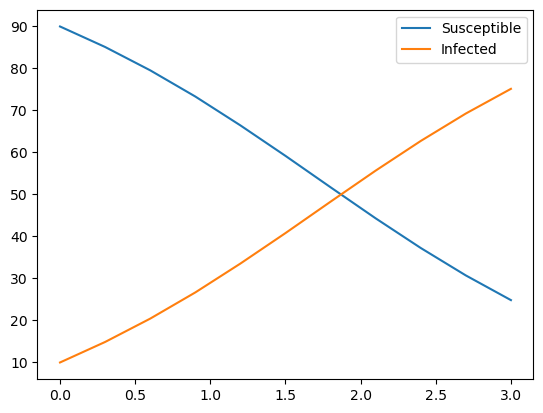

In [15]:
tau = 0.3  # Leap size

n_runs = 10000
runs = []
Kruns = []

start = time()
for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, K, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau, returnK=True)
    runs.append(X)
    Kruns.append(K)
end = time()

print('Computed in: ', np.round(end-start, 3))

print('Number of steps: ', len(X))

Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(t_tau, Xs, label='Susceptible')
plt.plot(t_tau, Xi, label='Infected')
plt.legend()

In [5]:
np.mean(Kruns, axis=0)

array([[2.209, 2.659],
       [3.005, 2.601],
       [3.863, 2.377],
       [4.691, 2.215],
       [5.395, 1.936],
       [5.813, 1.805],
       [5.924, 1.456],
       [5.931, 1.356],
       [5.47 , 1.063],
       [4.912, 0.869]])

## Mean-field

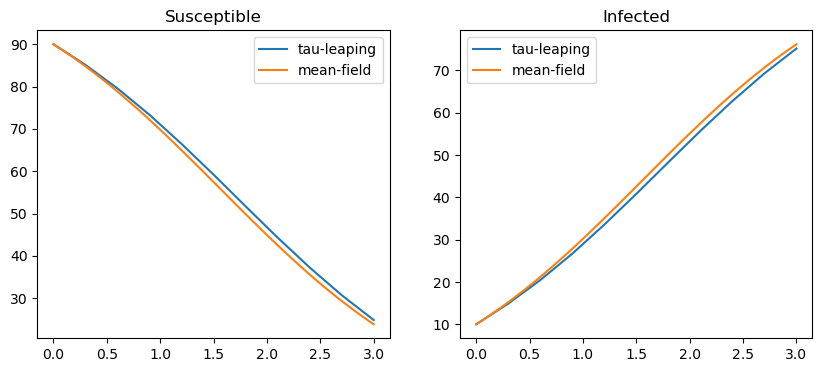

In [16]:
tmf = np.linspace(0,T, 100)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(t_tau, Xs, label='tau-leaping')
axs[0].plot(tmf, Xmf[:,0], label='mean-field')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(t_tau, Xi, label='tau-leaping')
axs[1].plot(tmf, Xmf[:,1], label='mean-field')
axs[1].set_title('Infected')
axs[1].legend()

## SOGA - Gaussian Approximation

In [7]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/SIJoint.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist, dynams = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

tot 0.999999999999999
mean: [3.02476896 2.5542    ]
cov:
 [[ 3.16330924 -0.02459238]
 [-0.02459238  2.558574  ]]
tot 0.999999999019473
mean: [3.85414259 2.38683093]
cov:
 [[ 4.26662768 -0.08621144]
 [-0.08621144  2.40505836]]
tot 0.999999996504634
mean: [4.58005814 2.19960171]
cov:
 [[ 5.2055372  -0.16057486]
 [-0.16057486  2.24263735]]
tot 0.999999999892424
mean: [5.12977665 1.99621193]
cov:
 [[ 5.78209792 -0.21200152]
 [-0.21200152  2.07631941]]
tot 0.999999605714107
mean: [5.43985645 1.7824323 ]
cov:
 [[ 5.97688424 -0.19624258]
 [-0.19624258  1.91271682]]
tot 0.999811583472859
mean: [5.47025839 1.56578421]
cov:
 [[ 6.03430145 -0.06620808]
 [-0.06620808  1.75961557]]
tot 0.995395022772405
mean: [5.20202336 1.35548984]
cov:
 [[6.52444941 0.23436968]
 [0.23436968 1.62430551]]
tot 0.935057139851204
mean: [4.48913797 1.12054101]
cov:
 [[8.58366915 0.88368421]
 [0.88368421 1.50296484]]
tot 1.11798994292487
mean: [5.06942199 1.26006567]
cov:
 [[8.00339325 0.30009192]
 [0.30009192 1.4668029

In [17]:
Kmeans = np.mean(np.array(Kruns), axis=0)
Kvars = np.var(np.array(Kruns), axis=0)
Kvars

array([[2.18091079, 2.73925756],
       [3.205311  , 2.51995164],
       [4.02841591, 2.37504991],
       [4.87747679, 2.27097839],
       [5.506879  , 2.05919936],
       [5.68881596, 1.78812444],
       [5.98202975, 1.58634975],
       [5.85719959, 1.38713031],
       [5.65409351, 1.124076  ],
       [5.39806271, 0.95648999]])

In [18]:
Kruns = np.array(Kruns)

sec_mom = []

for t in range(Kruns.shape[1]):
    ek1k2 = 0
    for run in range(Kruns.shape[0]):
        ek1k2 = ek1k2 + Kruns[run, t, 0]*Kruns[run, t, 1]
    sec_mom.append(ek1k2)
    
sec_mom = np.array(sec_mom)/1000
sec_mom = sec_mom - Kmeans[:,0]*Kmeans[:,1]

sec_mom

array([53.07543918, 68.7360098 , 81.98205459, 91.90250791, 93.8322088 ,
       90.27536068, 81.35339775, 68.84483777, 55.5302474 , 42.40925723])

In [19]:
Kruns.shape

(10000, 10, 2)

In [20]:
t = len(t_tau)

xs = np.zeros(t)
xi = np.zeros(t)
stds = np.zeros(t)
stdi = np.zeros(t)

for i in range(t):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

Text(0, 0.5, 'Number of individuals')

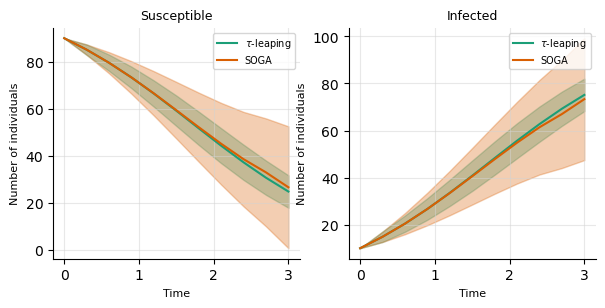

In [21]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)

In [13]:
xs = np.array(dynams['xs'])
stds = np.sqrt(np.array(dynams['stds']))
xi = np.array(dynams['xi'])
stdi = np.sqrt(np.array(dynams['stdi']))

Text(0, 0.5, 'Number of individuals')

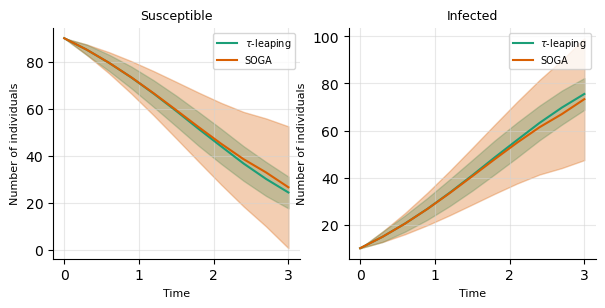

In [14]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

stdS = np.std(np.array(runs)[:,:,0], axis=0)
stdI = np.std(np.array(runs)[:,:,1], axis=0)

axs[0].plot(t_tau, Xs, label=r'$\tau$-leaping', color=colors[0])
axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
#axs[0].plot(tmf, Xmf[:,0], label='mean-field', color='green')
axs[0].plot(t_tau, xs, label='SOGA', color=colors[1])
axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].set_title('Susceptible', fontsize=9)
#axs[0].axhline(0)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)

axs[1].plot(t_tau, Xi, label=r'$\tau$-leaping', color = colors[0])
axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
#axs[1].plot(tmf, Xmf[:,1], label='mean-field', color='green')
axs[1].plot(t_tau, xi, label='SOGA', color=colors[1])
axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].set_title('Infected', fontsize=9)
#axs[1].axhline(0)
axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)